# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Sorting data according to Time in ascending order
sorted_data=sorted_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73591
0    14182
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!<br /><br />(For those wo

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!(For those wondering, this mix requ

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love Pretzels and have to say that after trying my way through many different kinds, these are The BEST.<br /><br />The taste great, are REALLY crunchy - a key requirement for me - and have just the right amount of salt. The Newman is Rounds are just as good - maybe even better.<br /><br />And as an added bonus, Paul Newmann donates all his after tax profits from the sale of his products to charity - an unbeatable combination in my book!


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love Pretzels and have to say that after trying my way through many different kinds these are The BEST br br The taste great are REALLY crunchy a key requirement for me and have just the right amount of salt The Newman is Rounds are just as good maybe even better br br And as an added bonus Paul Newmann donates all his after tax profits from the sale of his products to charity an unbeatable combination in my book 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:47<00:00, 1858.63it/s]


In [25]:
preprocessed_reviews[1500]

'love pretzels say trying way many different kinds best taste great really crunchy key requirement right amount salt newman rounds good maybe even better added bonus paul newmann donates tax profits sale products charity unbeatable combination book'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also.

preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:33<00:00, 2586.74it/s]


In [27]:
#Splitting the data into train,CV and test

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(preprocessed_reviews,final['Score'],random_state=100,test_size=0.30,shuffle=False)

X_train2,X_CV,y_train2,y_CV = train_test_split(X_train,y_train,random_state=100,test_size=0.30,shuffle=False)

# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

#Vectorizing the train2 (splitted from X_train to be used with CV data)
final_counts2 = count_vect.transform(X_train2)

#Vectorizing the CV data
final_countsCV = count_vect.transform(X_CV)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 45802)
the number of unique words  45802


In [29]:
#Vectorizing the test data

final_countsTEST = count_vect.transform(X_test)

## [4.2] Bi-Grams and n-Grams.

In [30]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_bi = CountVectorizer(ngram_range=(2,2), min_df=10, max_features=5000)
count_vect_bi.fit(X_train)
features_bigrams = count_vect_bi.get_feature_names()
final_bigram_counts =count_vect_bi.transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 5000)
the number of unique words including both unigrams and bigrams  5000


In [31]:

final_bigram_counts2 = count_vect_bi.transform(X_train2)
final_bigram_countsCV = count_vect_bi.transform(X_CV)
final_bigram_countsTEST = count_vect_bi.transform(X_test)

## [4.3] TF-IDF

In [32]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

features_tf_idf = tf_idf_vect.get_feature_names()

final_tf_idf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 36163)
the number of unique words including both unigrams and bigrams  36163


In [33]:
final_tf_idf2 = tf_idf_vect.transform(X_train2)
final_tf_idfCV = tf_idf_vect.transform(X_CV)
final_tf_idfTEST = tf_idf_vect.transform(X_test)

## [4.4] Word2Vec

In [34]:
i=0
list_of_sentence_train=[]
for sentence in X_train2:
    list_of_sentence_train.append(sentence.split())

In [35]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [36]:
w2v_model=Word2Vec(list_of_sentence_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12484
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


#### [4.4.1.1] Avg W2v

### Converting Train data text

In [37]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [01:43<00:00, 417.15it/s]


(43008, 50)
[-0.05134904  0.35220953 -0.96987229 -0.47305027  0.0383171  -0.11376017
 -0.2502348  -0.03885052 -0.05229941  0.19550582  0.26438238  0.03406128
  0.0590713  -0.16212343  0.06252739 -0.21109254 -0.45540157 -0.40273549
 -0.09670921 -0.122541    0.11755737  0.02639356 -0.13145043  0.14782022
  0.30250934 -0.52020207  0.01584321  0.27326955  0.07171063  0.45687335
 -0.35937575 -0.38798928 -0.29708202 -0.03318852  0.53222122  0.04584507
  0.04803459  0.32479108  0.16038684 -0.20299043  0.31593718  0.30511577
  0.09580162 -0.83124443 -0.28415743 -0.18712365 -0.13739534 -0.26482346
  0.29271427  0.58506272]


### Converting CV data text

In [38]:
i=0
list_of_sentence_cv=[]
for sentence in X_CV:
    list_of_sentence_cv.append(sentence.split())

In [39]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 18433/18433 [00:46<00:00, 399.68it/s]


(18433, 50)
[ 0.57531241 -0.46035049 -0.29816481 -0.07007674  0.40929277 -0.34065365
 -1.08278155  0.0453903  -0.28074281  0.05345293 -0.04730473  0.12188068
 -0.48407225  1.06727777  1.31876268 -0.60086085 -0.42263671 -0.49025416
 -0.39042496 -0.32921636  0.37418376 -0.46823395 -0.84624856 -0.04552577
  0.65385966  0.07335554  1.02074601  1.24113415  0.26158472  0.78768862
 -0.01644331 -0.50144688 -0.15293011  0.0396711   0.25542049  0.20692007
  0.51493516 -0.2341974   0.04441897  0.15171295  1.33561542 -0.7886905
 -1.05798118  0.12114729 -0.81646362  0.10986852 -0.2635831   0.24731986
  0.03015959  0.85565476]


### Converting Test data text

In [40]:
i=0
list_of_sentence_test=[]
for sentence in X_test:
    list_of_sentence_test.append(sentence.split())

In [41]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [01:10<00:00, 374.44it/s]


(26332, 50)
[-0.19246034  0.4841615  -0.73119578 -0.6897122   0.147795   -0.09734136
 -0.11627399  0.21776517  0.01826416  0.35584912  0.04145975  0.25050957
 -0.29721138  0.10318631  0.38462391 -0.06950154 -0.13141525 -0.51530292
 -0.19570527  0.13361483  0.06495207  0.20827738 -0.51038971 -0.06763539
  0.30659467 -0.71648076  0.22252351  0.51747295  0.06048606  0.31145401
 -0.10353297 -0.60884645 -0.70959489 -0.13752965  0.14336296 -0.26302907
 -0.31571779  0.02979721  0.44270336 -0.06451125  0.43439373  0.23068936
  0.11512369 -0.95392907 -0.68254978  0.03418672 -0.46633947 -0.12755072
  0.04035979  0.44884276]


#### [4.4.1.2] TFIDF weighted W2v

In [42]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model_tf = TfidfVectorizer()
tf_idf_matrix = model_tf.fit_transform(X_train2)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_tf.get_feature_names(), list(model_tf.idf_)))

### For train data

In [43]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_tf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 43008/43008 [17:16<00:00, 41.50it/s]


### For CV data

In [44]:

tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 18433/18433 [07:50<00:00, 39.22it/s]


### For test data

In [45]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [11:19<00:00, 38.75it/s]


In [46]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
tfidf_sent_vectors_CV = np.array(tfidf_sent_vectors_CV)
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [47]:
# Please write all the code with proper documentation

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

hyperparameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100],'n_estimators':list(range(50,500,50))}

RS = RandomizedSearchCV(RandomForestClassifier(),param_distributions=hyperparameters,cv=5,random_state=100,scoring='roc_auc',return_train_score=True)
RS.fit(final_bigram_counts2,y_train2)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [48]:
print('Best Estimator : ',RS.best_estimator_)
print('\nClasses : ',RS.classes_)
print('\nBest Score : ',RS.best_score_)
print('\nNo of Splits : ',RS.n_splits_)
print('\nBest params : ',RS.best_params_)

Best Estimator :  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classes :  [0 1]

Best Score :  0.8097150566625215

No of Splits :  5

Best params :  {'n_estimators': 300, 'max_depth': 50}


In [49]:
optimal_depth = RS.best_params_['max_depth']
optimal_estimators = RS.best_params_['n_estimators']

print('Optimal Depth : ',optimal_depth)
print('Optimal_estimators : ',optimal_estimators)

Optimal Depth :  50
Optimal_estimators :  300


In [50]:
best_auc_bow_rf = RS.best_score_

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [51]:
# Please write all the code with proper documentation

model_RF = RandomForestClassifier(max_depth=optimal_depth,n_estimators=optimal_estimators)
model_RF.fit(final_bigram_counts,y_train)

print('Top 20 features : ',np.take(np.asarray(features_bigrams),model_RF.feature_importances_.argsort()[::-1][:20]))

Top 20 features :  ['not buy' 'waste money' 'not worth' 'would not' 'not recommend'
 'not even' 'not good' 'not waste' 'never buy' 'not buying' 'not purchase'
 'not taste' 'not order' 'two stars' 'made china' 'bad batch'
 'buyer beware' 'tasted like' 'product not' 'wanted like']


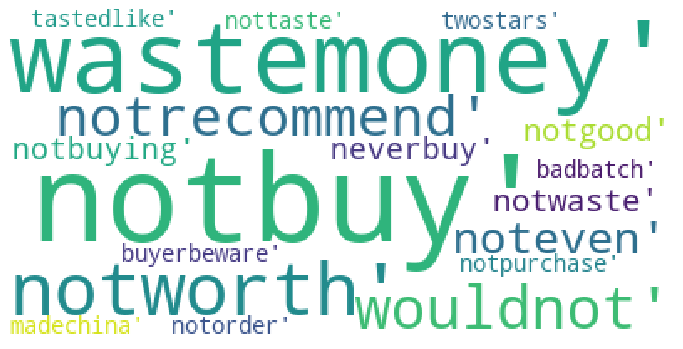

In [52]:
from wordcloud import WordCloud, STOPWORDS 

top_20_features = np.take(np.asarray(features_bigrams),model_RF.feature_importances_.argsort()[::-1][:20])

top=[]
for words in top_20_features:
    top.append(''.join(words.split()))
    
wordcloud = WordCloud(width=400,height=200,background_color='white',min_font_size=10).generate(str(top))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [53]:
AUC_bow_train2 = RS.cv_results_['mean_train_score']
AUC_bow_CV = RS.cv_results_['mean_test_score']

In [54]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

In [55]:
depth =[1, 5, 10, 50, 100, 500, 100]
estimators = list(range(50,500,50))
                  
trace1 = go.Scatter3d(x=estimators,y=depth,z=AUC_bow_train2, name = 'train')
trace2 = go.Scatter3d(x=estimators,y=depth,z=AUC_bow_CV, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

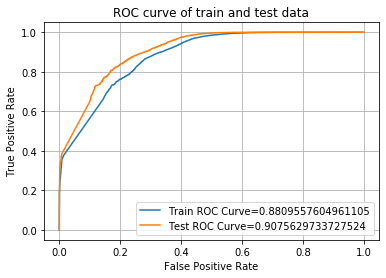

In [56]:
model_bi = RandomForestClassifier(max_depth=optimal_depth,n_estimators=optimal_estimators)
model_bi1 = model_bi.fit(final_bigram_counts,y_train)

y_pred_bi = model_bi.predict_proba(final_bigram_counts)[:,1]
fpr_train,tpr_train,t1 = metrics.roc_curve(y_train,y_pred_bi)

model_bi2 = model_bi.fit(final_bigram_countsTEST,y_test)
y_pred_bi2 = model_bi2.predict_proba(final_bigram_countsTEST)[:,1]
fpr_test,tpr_test,t2 = metrics.roc_curve(y_test,y_pred_bi2)

plt.plot(fpr_train,tpr_train,label='Train ROC Curve=' +str(metrics.auc(fpr_train,tpr_train)))
plt.plot(fpr_test,tpr_test,label='Test ROC Curve=' +str(metrics.auc(fpr_test,tpr_test)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

In [57]:
#function to calculate the threshold value with high tpr and low fpr

def find_best_threshold(thresh, fpr, tpr):
    t = thresh[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

#function to get the predictions with best threshold
def predict_with_best_t(proba, thresh):
    predictions = []
    for i in proba:
        if i>=thresh:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.6218559355844111 for threshold 0.858
*********Train confusion matrix*********
[[ 6925  2701]
 [ 7026 44789]]


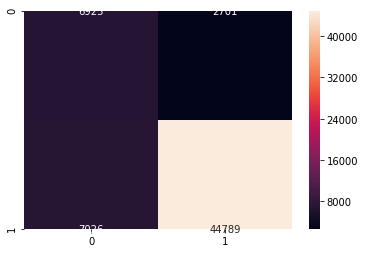

In [58]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr_train,tpr_train)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train, predict_with_best_t(y_pred_bi, best_t)))
cm_tr = confusion_matrix(y_train, predict_with_best_t(y_pred_bi, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')


*********Test confusion matrix*********
[[ 3595   961]
 [ 3333 18443]]


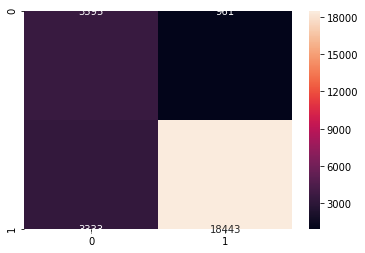

In [59]:

print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_bi2, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_bi2, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [60]:
hyperparameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100],'n_estimators':list(range(50,500,50))}

RS_tf = RandomizedSearchCV(RandomForestClassifier(),param_distributions=hyperparameters,cv=5,random_state=100,scoring='roc_auc',return_train_score=True)
RS_tf.fit(final_tf_idf2,y_train2)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [61]:
print('Best Estimator : ',RS_tf.best_estimator_)
print('\nClasses : ',RS_tf.classes_)
print('\nBest Score : ',RS_tf.best_score_)
print('\nNo of Splits : ',RS_tf.n_splits_)
print('\nBest params : ',RS_tf.best_params_)

Best Estimator :  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classes :  [0 1]

Best Score :  0.9232546591484679

No of Splits :  5

Best params :  {'n_estimators': 450, 'max_depth': 100}


In [62]:
#Calculating AUC scores for each corresponding hyperparameters
depth = [1, 5, 10, 50, 100, 500, 100]
estimators = list(range(50,500,50))

AUC_tf_idf_train = RS_tf.cv_results_['mean_train_score']
AUC_tf_idf_CV = RS_tf.cv_results_['mean_test_score']

In [63]:
optimal_depth_tf = RS_tf.best_params_['max_depth']
optimal_estimators_tf = RS_tf.best_params_['n_estimators']

print('Optimal Depth : ',optimal_depth_tf)
print('Optimal_estimators : ',optimal_estimators_tf)

Optimal Depth :  100
Optimal_estimators :  450


In [64]:
best_auc_tfidf_rf = RS_tf.best_score_

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [65]:
# Please write all the code with proper documentation

from wordcloud import WordCloud, STOPWORDS 

#finding the top 20 features

model_RF_tf = RandomForestClassifier()
model_RF_tf.fit(final_tf_idf,y_train)

print('Top 20 features : ',np.take(np.asarray(features_tf_idf),model_RF_tf.feature_importances_.argsort()[::-1][:20]))


Top 20 features :  ['not' 'worst' 'bad' 'waste money' 'awful' 'not worth' 'horrible'
 'disappointed' 'great' 'terrible' 'would' 'not buy' 'thought' 'waste'
 'stale' 'not recommend' 'return' 'best' 'money' 'threw']


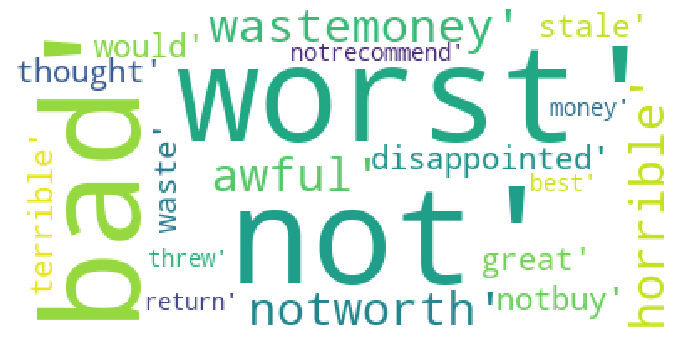

In [66]:
top_20_features_tf = np.take(np.asarray(features_tf_idf),model_RF_tf.feature_importances_.argsort()[::-1][:20])

top_tf=[]
for words in top_20_features_tf:
    top_tf.append(''.join(words.split()))
    
wordcloud = WordCloud(width=400,height=200,background_color='white',min_font_size=10).generate(str(top_tf))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [67]:
trace1 = go.Scatter3d(x=estimators,y=depth,z=AUC_tf_idf_train, name = 'train')
trace2 = go.Scatter3d(x=estimators,y=depth,z=AUC_tf_idf_CV, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

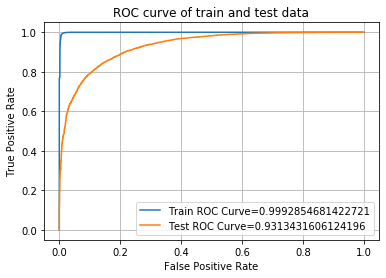

In [68]:
model_tf = RandomForestClassifier(max_depth=optimal_depth_tf,n_estimators=optimal_estimators_tf)
model_tf.fit(final_tf_idf2,y_train2)

y_pred_tf_train = model_tf.predict_proba(final_tf_idf2)[:,1]
fpr_tf,tpr_tf,t1 = metrics.roc_curve(y_train2,y_pred_tf_train)

y_pred_tf_test = model_tf.predict_proba(final_tf_idfTEST)[:,1]
fpr_tf2,tpr_tf2,t2 = metrics.roc_curve(y_test,y_pred_tf_test)

plt.plot(fpr_tf,tpr_tf,label='Train ROC Curve=' +str(metrics.auc(fpr_tf,tpr_tf)))
plt.plot(fpr_tf2,tpr_tf2,label='Test ROC Curve=' +str(metrics.auc(fpr_tf2,tpr_tf2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.9835951003872985 for threshold 0.832
*********Train confusion matrix*********
[[ 6295    65]
 [  229 36419]]


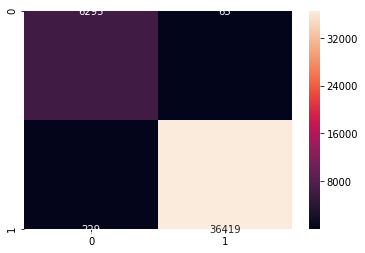

In [69]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr_tf,tpr_tf)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_tf_train, best_t)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_tf_train, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[ 3787   769]
 [ 2974 18802]]


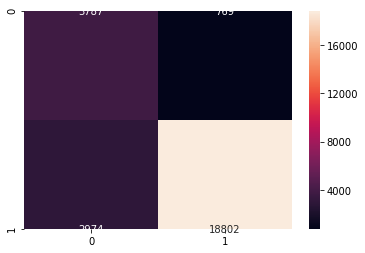

In [70]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_tf_test, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_tf_test, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [71]:
# Please write all the code with proper documentation

hyperparameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100],'n_estimators':list(range(50,500,50))}

RS_w2v = RandomizedSearchCV(RandomForestClassifier(),param_distributions=hyperparameters,cv=5,random_state=100,scoring='roc_auc',return_train_score=True)
RS_w2v.fit(sent_vectors_train,y_train2)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [72]:
print('Best Estimator : ',RS_w2v.best_estimator_)
print('\nClasses : ',RS_w2v.classes_)
print('\nBest Score : ',RS_w2v.best_score_)
print('\nNo of Splits : ',RS_w2v.n_splits_)
print('\nBest params : ',RS_w2v.best_params_)

Best Estimator :  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classes :  [0 1]

Best Score :  0.88269746352089

No of Splits :  5

Best params :  {'n_estimators': 450, 'max_depth': 100}


In [73]:
#Calculating AUC scores for each corresponding hyperparameters
depth = [1, 5, 10, 50, 100, 500, 100]
estimators = list(range(50,500,50))

AUC_w2v_train = RS_w2v.cv_results_['mean_train_score']
AUC_w2v_CV = RS_w2v.cv_results_['mean_test_score']


In [74]:
trace1 = go.Scatter3d(x=estimators,y=depth,z=AUC_w2v_train, name = 'train')
trace2 = go.Scatter3d(x=estimators,y=depth,z=AUC_w2v_CV, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [75]:
optimal_depth_w2v = RS_w2v.best_params_['max_depth']
optimal_estimators_w2v = RS_w2v.best_params_['n_estimators']

print('Optimal Depth : ',optimal_depth_w2v)
print('Optimal_estimators : ',optimal_estimators_w2v)

Optimal Depth :  100
Optimal_estimators :  450


In [76]:
best_auc_w2v_rf = RS_w2v.best_score_

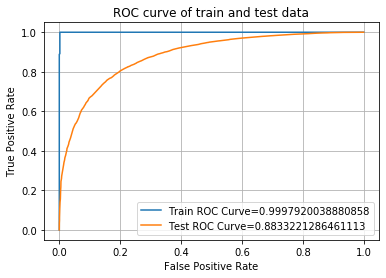

In [77]:
model_w2v = RandomForestClassifier(max_depth=optimal_depth_w2v,n_estimators=optimal_estimators_w2v)
model_w2v.fit(sent_vectors_train,y_train2)

y_pred_w2v_train = model_w2v.predict_proba(sent_vectors_train)[:,1]
fpr_w2v,tpr_w2v,t1 = metrics.roc_curve(y_train2,y_pred_w2v_train)

y_pred_w2v_test = model_w2v.predict_proba(sent_vectors_test)[:,1]
fpr_w2v2,tpr_w2v2,t2 = metrics.roc_curve(y_test,y_pred_w2v_test)

plt.plot(fpr_w2v,tpr_w2v,label='Train ROC Curve=' +str(metrics.auc(fpr_w2v,tpr_w2v)))
plt.plot(fpr_w2v2,tpr_w2v2,label='Test ROC Curve=' +str(metrics.auc(fpr_w2v2,tpr_w2v2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.9981132075471698 for threshold 0.689
*********Train confusion matrix*********
[[ 6348    12]
 [    0 36648]]


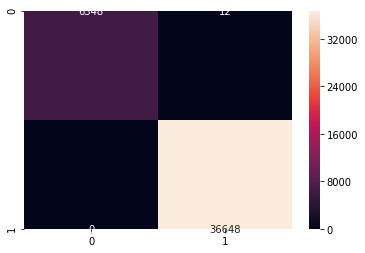

In [78]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr_w2v,tpr_w2v)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_w2v_train, best_t)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_w2v_train, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')



*********Test confusion matrix*********
[[ 2727  1829]
 [ 1673 20103]]


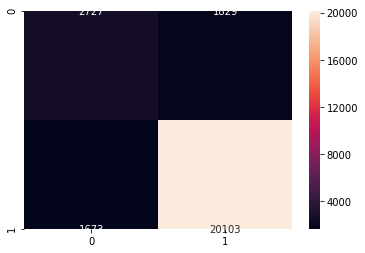

In [79]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_w2v_test, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_w2v_test, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [80]:
# Please write all the code with proper documentation

hyperparameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100],'n_estimators':list(range(50,500,50))}

RS_t2v = RandomizedSearchCV(RandomForestClassifier(),param_distributions=hyperparameters,cv=5,random_state=100,scoring='roc_auc',return_train_score=True)
RS_t2v.fit(tfidf_sent_vectors_train,y_train2)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [81]:
print('Best Estimator : ',RS_t2v.best_estimator_)
print('\nClasses : ',RS_t2v.classes_)
print('\nBest Score : ',RS_t2v.best_score_)
print('\nNo of Splits : ',RS_t2v.n_splits_)
print('\nBest params : ',RS_t2v.best_params_)

Best Estimator :  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classes :  [0 1]

Best Score :  0.8564190710910144

No of Splits :  5

Best params :  {'n_estimators': 450, 'max_depth': 100}


In [82]:
#Calculating AUC scores for each corresponding hyperparameters
depth = [1, 5, 10, 50, 100, 500, 100]
estimators = list(range(50,500,50))

AUC_t2v_train = RS_t2v.cv_results_['mean_train_score']
AUC_t2v_CV = RS_t2v.cv_results_['mean_test_score']

In [83]:
trace1 = go.Scatter3d(x=estimators,y=depth,z=AUC_t2v_train, name = 'train')
trace2 = go.Scatter3d(x=estimators,y=depth,z=AUC_t2v_CV, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [84]:
optimal_depth_t2v = RS_t2v.best_params_['max_depth']
optimal_estimators_t2v = RS_t2v.best_params_['n_estimators']

print('Optimal Depth : ',optimal_depth_t2v)
print('Optimal_estimators : ',optimal_estimators_t2v)

Optimal Depth :  100
Optimal_estimators :  450


In [85]:
best_auc_t2v_rf = RS_t2v.best_score_

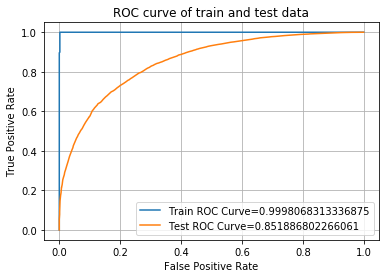

In [86]:
model_t2v = RandomForestClassifier(max_depth=optimal_depth_t2v,n_estimators=optimal_estimators_t2v)
model_t2v.fit(tfidf_sent_vectors_train,y_train2)

y_pred_t2v_train = model_t2v.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr_t2v,tpr_t2v,t = metrics.roc_curve(y_train2,y_pred_t2v_train)

y_pred_t2v_test = model_t2v.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr_t2v2,tpr_t2v2,t = metrics.roc_curve(y_test,y_pred_t2v_test)

plt.plot(fpr_t2v,tpr_t2v,label='Train ROC Curve=' +str(metrics.auc(fpr_t2v,tpr_t2v)))
plt.plot(fpr_t2v2,tpr_t2v2,label='Test ROC Curve=' +str(metrics.auc(fpr_t2v2,tpr_t2v2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.9981132075471698 for threshold 0.902
*********Train confusion matrix*********
[[ 6360     0]
 [ 4013 32635]]


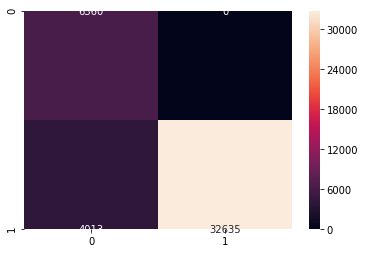

In [133]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr_t2v,tpr_t2v)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_t2v_train, best_t)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_t2v_train, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')


*********Test confusion matrix*********
[[ 4240   316]
 [10885 10891]]


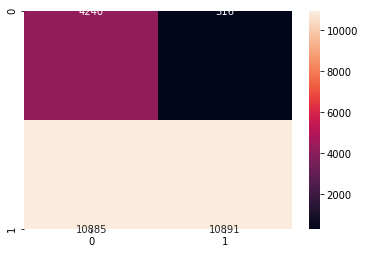

In [134]:

print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_t2v_test, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_t2v_test, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [89]:
# Please write all the code with proper documentation

import xgboost
from xgboost.sklearn import XGBClassifier

In [90]:
hyperparameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100],'n_estimators':list(range(50,500,50)),'learning_rate':list(np.arange(0.1,1.0,0.1))}

XGB = RandomizedSearchCV(XGBClassifier(),param_distributions=hyperparameters,cv=5,random_state=30,scoring='roc_auc',return_train_score=True)
XGB.fit(final_bigram_counts2,y_train2)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distr

In [91]:
print('Best Estimator : ',XGB.best_estimator_)
print('\nClasses : ',XGB.classes_)
print('\nBest Score : ',XGB.best_score_)
print('\nNo of Splits : ',XGB.n_splits_)
print('\nBest params : ',XGB.best_params_)

Best Estimator :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=100,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Classes :  [0 1]

Best Score :  0.873239995960955

No of Splits :  5

Best params :  {'n_estimators': 400, 'max_depth': 100, 'learning_rate': 0.1}


In [92]:
#Calculating AUC scores for each corresponding hyperparameters
depth = [1, 5, 10, 50, 100, 500, 100]
estimators = list(range(50,500,50))

AUC_bow_train2_XGB = XGB.cv_results_['mean_train_score']
AUC_bow_CV_XGB = XGB.cv_results_['mean_test_score']

In [93]:
trace1 = go.Scatter3d(x=estimators,y=depth,z=AUC_bow_train2_XGB, name = 'train')
trace2 = go.Scatter3d(x=estimators,y=depth,z=AUC_bow_CV_XGB, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [94]:
optimal_depth_XGB = XGB.best_params_['max_depth']
optimal_estimators_XGB = XGB.best_params_['n_estimators']
optimal_rate_XGB = XGB.best_params_['learning_rate']

print('Optimal Depth : ',optimal_depth_XGB)
print('Optimal_estimators : ',optimal_estimators_XGB)
print('Optimal Learning Rate : ',optimal_rate_XGB)

Optimal Depth :  100
Optimal_estimators :  400
Optimal Learning Rate :  0.1


In [95]:
best_auc_bow_xgb = XGB.best_score_

In [96]:
from wordcloud import WordCloud, STOPWORDS 

#finding the top 20 features

model_XGB = XGBClassifier(max_depth=optimal_depth_XGB,n_estimators=optimal_estimators_XGB,learning_rate=optimal_rate_XGB)
model_XGB.fit(final_bigram_counts,y_train)

print('Top 20 features : ',np.take(np.asarray(features_bigrams),model_XGB.feature_importances_.argsort()[::-1][:20]))

Top 20 features :  ['waste money' 'not worth' 'buyer beware' 'not buying' 'two stars'
 'threw away' 'never buy' 'not ordering' 'highly recommend' 'not return'
 'throw away' 'never order' 'not buy' 'bad batch' 'high hopes'
 'not purchase' 'wanted like' 'money back' 'worst tasting'
 'really disappointed']


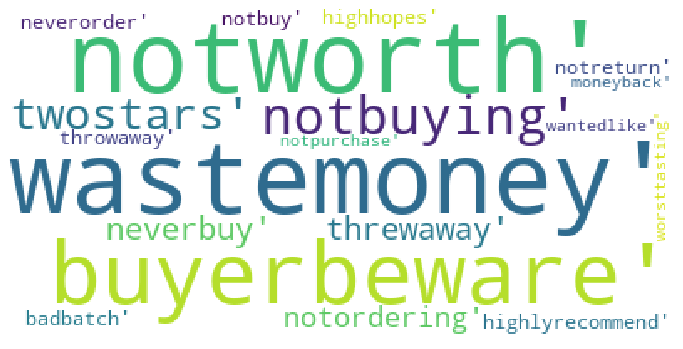

In [97]:
top_20_features_XGB = np.take(np.asarray(features_bigrams),model_XGB.feature_importances_.argsort()[::-1][:20])

top=[]
for words in top_20_features_XGB:
    top.append(''.join(words.split()))
    
wordcloud = WordCloud(width=400,height=200,background_color='white',min_font_size=10).generate(str(top))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

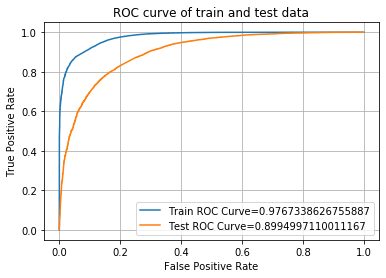

In [98]:
#using the model with optimal parameters #model_XGB

y_pred_bi = model_XGB.predict_proba(final_bigram_counts)[:,1]
fpr_bi,tpr_bi,t1 = metrics.roc_curve(y_train,y_pred_bi)

y_pred_bi2 = model_XGB.predict_proba(final_bigram_countsTEST)[:,1]
fpr_bi2,tpr_bi2,t2 = metrics.roc_curve(y_test,y_pred_bi2)

plt.plot(fpr_bi,tpr_bi,label='Train ROC Curve=' +str(metrics.auc(fpr_bi,tpr_bi)))
plt.plot(fpr_bi2,tpr_bi2,label='Test ROC Curve=' +str(metrics.auc(fpr_bi2,tpr_bi2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.8285353209755358 for threshold 0.826
*********Train confusion matrix*********
[[ 9094   532]
 [ 6373 45442]]


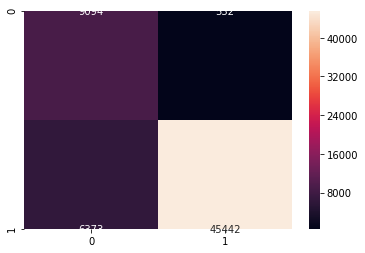

In [99]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr_bi,tpr_bi)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train, predict_with_best_t(y_pred_bi, best_t)))
cm_tr = confusion_matrix(y_train, predict_with_best_t(y_pred_bi, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')


*********Test confusion matrix*********
[[ 3625   931]
 [ 3602 18174]]


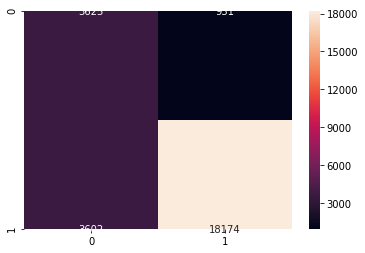

In [100]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_bi2, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_bi2, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [101]:
hyperparameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100],'n_estimators':list(range(50,500,50)),'learning_rate':list(np.arange(0.1,1.0,0.1))}

XGB_tf = RandomizedSearchCV(XGBClassifier(),param_distributions=hyperparameters,cv=5,random_state=30,scoring='roc_auc',return_train_score=True)
XGB_tf.fit(final_tf_idf2,y_train2)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distr

In [102]:
print('Best Estimator : ',XGB_tf.best_estimator_)
print('\nClasses : ',XGB_tf.classes_)
print('\nBest Score : ',XGB_tf.best_score_)
print('\nNo of Splits : ',XGB_tf.n_splits_)
print('\nBest params : ',XGB_tf.best_params_)

Best Estimator :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.30000000000000004, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Classes :  [0 1]

Best Score :  0.9416040627117257

No of Splits :  5

Best params :  {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.30000000000000004}


In [103]:
#Calculating AUC scores for each corresponding hyperparameters
depth = [1, 5, 10, 50, 100, 500, 100]
estimators = list(range(50,500,50))

AUC_tf_train2_XGB = XGB_tf.cv_results_['mean_train_score']
AUC_tf_CV_XGB = XGB_tf.cv_results_['mean_test_score']

In [104]:
trace1 = go.Scatter3d(x=estimators,y=depth,z=AUC_tf_train2_XGB, name = 'train')
trace2 = go.Scatter3d(x=estimators,y=depth,z=AUC_tf_CV_XGB, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [105]:
optimal_depth_XGB_tf = XGB_tf.best_params_['max_depth']
optimal_estimators_XGB_tf = XGB_tf.best_params_['n_estimators']
optimal_rate_XGB_tf = XGB_tf.best_params_['learning_rate']

print('Optimal Depth : ',optimal_depth_XGB_tf)
print('Optimal_estimators : ',optimal_estimators_XGB_tf)
print('Optimal Learning Rate : ',optimal_rate_XGB_tf)

Optimal Depth :  5
Optimal_estimators :  400
Optimal Learning Rate :  0.30000000000000004


In [106]:
best_auc_tfidf_xgb = XGB_tf.best_score_

In [107]:
model_XGB_tf = XGBClassifier(max_depth=optimal_depth_XGB_tf,n_estimators=optimal_estimators_XGB_tf,learning_rate=optimal_rate_XGB_tf)
model_XGB_tf.fit(final_tf_idf,y_train)

print('Top 20 features : ',np.take(np.asarray(features_tf_idf),model_XGB_tf.feature_importances_.argsort()[::-1][:20]))

Top 20 features :  ['refund' 'awful' 'worst' 'waste' 'horrible' 'not buy' 'return' 'threw'
 'disappointed' 'not disappointed' 'description' 'would recommend'
 'delicious' 'disappointing' 'not recommend' 'terrible' 'highly' 'money'
 'easy' 'favorite']


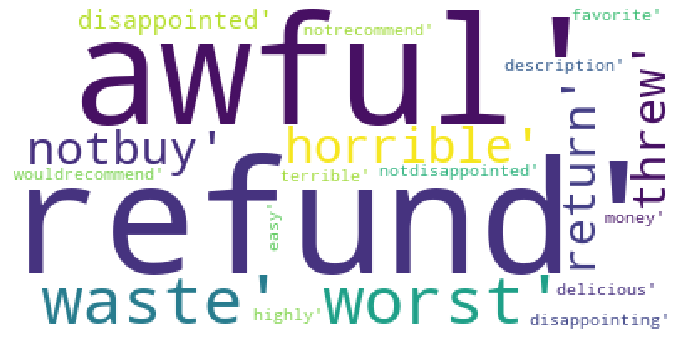

In [108]:
top_20_XGB_tf = np.take(np.asarray(features_tf_idf),model_XGB_tf.feature_importances_.argsort()[::-1][:20])

top=[]
for words in top_20_XGB_tf:
    top.append(''.join(words.split()))
    
wordcloud = WordCloud(width=400,height=200,background_color='white',min_font_size=10).generate(str(top))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

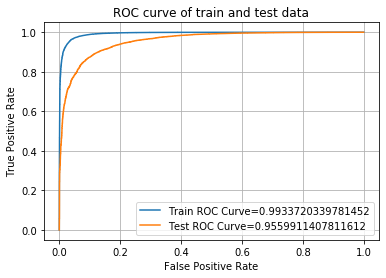

In [109]:
y_pred_tf = model_XGB_tf.predict_proba(final_tf_idf)[:,1]
fpr_tf,tpr_tf,t1 = metrics.roc_curve(y_train,y_pred_tf)

y_pred_tf2 = model_XGB_tf.predict_proba(final_tf_idfTEST)[:,1]
fpr_tf2,tpr_tf2,t2 = metrics.roc_curve(y_test,y_pred_tf2)

plt.plot(fpr_tf,tpr_tf,label='Train ROC Curve=' +str(metrics.auc(fpr_tf,tpr_tf)))
plt.plot(fpr_tf2,tpr_tf2,label='Test ROC Curve=' +str(metrics.auc(fpr_tf2,tpr_tf2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.92499779307622 for threshold 0.765
*********Train confusion matrix*********
[[ 9250   376]
 [ 1938 49877]]


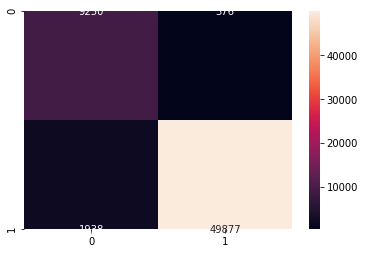

In [110]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr_tf,tpr_tf)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train, predict_with_best_t(y_pred_tf, best_t)))
cm_tr = confusion_matrix(y_train, predict_with_best_t(y_pred_tf, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[ 3764   792]
 [ 1584 20192]]


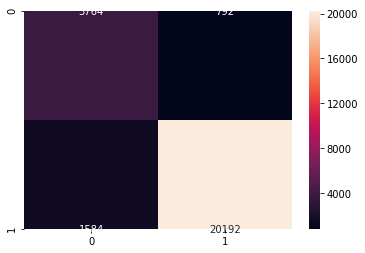

In [111]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_tf2, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_tf2, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [112]:
# Please write all the code with proper documentation

In [113]:
hyperparameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100],'n_estimators':list(range(50,500,50)),'learning_rate':list(np.arange(0.1,1.0,0.1))}

XGB_w2v = RandomizedSearchCV(XGBClassifier(),param_distributions=hyperparameters,cv=5,random_state=30,scoring='roc_auc',return_train_score=True)
XGB_w2v.fit(sent_vectors_train,y_train2)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distr

In [114]:
print('Best Estimator : ',XGB_w2v.best_estimator_)
print('\nClasses : ',XGB_w2v.classes_)
print('\nBest Score : ',XGB_w2v.best_score_)
print('\nNo of Splits : ',XGB_w2v.n_splits_)
print('\nBest params : ',XGB_w2v.best_params_)

Best Estimator :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=100,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Classes :  [0 1]

Best Score :  0.8987926066204889

No of Splits :  5

Best params :  {'n_estimators': 400, 'max_depth': 100, 'learning_rate': 0.1}


In [115]:
#Calculating AUC scores for each corresponding hyperparameters
depth = [1, 5, 10, 50, 100, 500, 100]
estimators = list(range(50,500,50))

AUC_w2v_train2_XGB = XGB_w2v.cv_results_['mean_train_score']
AUC_w2v_CV_XGB = XGB_w2v.cv_results_['mean_test_score']

In [116]:
trace1 = go.Scatter3d(x=estimators,y=depth,z=AUC_w2v_train2_XGB, name = 'train')
trace2 = go.Scatter3d(x=estimators,y=depth,z=AUC_w2v_CV_XGB, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [117]:
optimal_depth_XGB_w2v = XGB_w2v.best_params_['max_depth']
optimal_estimators_XGB_w2v = XGB_w2v.best_params_['n_estimators']
optimal_rate_XGB_w2v = XGB_w2v.best_params_['learning_rate']

print('Optimal Depth : ',optimal_depth_XGB_w2v)
print('Optimal_estimators : ',optimal_estimators_XGB_w2v)
print('Optimal Learning Rate : ',optimal_rate_XGB_w2v)

Optimal Depth :  100
Optimal_estimators :  400
Optimal Learning Rate :  0.1


In [118]:
best_auc_w2v_xgb = XGB_w2v.best_score_

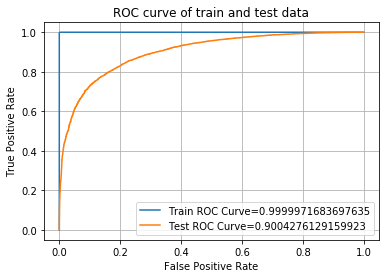

In [119]:
model_w2v = XGBClassifier(max_depth=optimal_depth_XGB_w2v,n_estimators=optimal_estimators_XGB_w2v,learning_rate=optimal_rate_XGB_w2v)
model_w2v.fit(sent_vectors_train,y_train2)

y_pred_w2v = model_w2v.predict_proba(sent_vectors_train)[:,1]
fpr_w2v,tpr_w2v,t1 = metrics.roc_curve(y_train2,y_pred_w2v)

y_pred_w2v2 = model_w2v.predict_proba(sent_vectors_test)[:,1]
fpr_w2v2,tpr_w2v2,t2 = metrics.roc_curve(y_test,y_pred_w2v2)

plt.plot(fpr_w2v,tpr_w2v,label='Train ROC Curve=' +str(metrics.auc(fpr_w2v,tpr_w2v)))
plt.plot(fpr_w2v2,tpr_w2v2,label='Test ROC Curve=' +str(metrics.auc(fpr_w2v2,tpr_w2v2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.9981132075471698 for threshold 0.902
*********Train confusion matrix*********
[[ 6348    12]
 [    0 36648]]


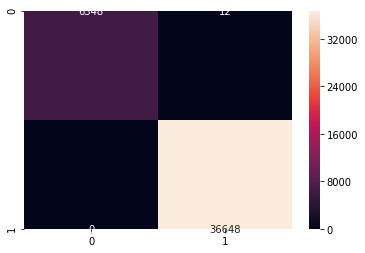

In [120]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr_w2v,tpr_w2v)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_w2v, best_t)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_w2v, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')


*********Test confusion matrix*********
[[ 2982  1574]
 [ 1942 19834]]


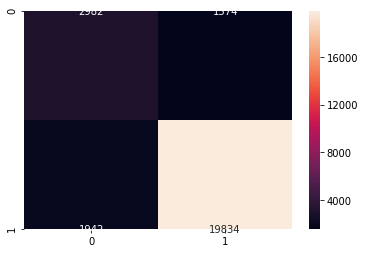

In [121]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_w2v2, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_w2v2, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [122]:
hyperparameters = {'max_depth':[1, 5, 10, 50, 100, 500, 100],'n_estimators':list(range(50,500,50)),'learning_rate':list(np.arange(0.1,1.0,0.1))}
#tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
XGB_t2v = RandomizedSearchCV(XGBClassifier(),param_distributions=hyperparameters,cv=5,random_state=30,scoring='roc_auc',return_train_score=True)
XGB_t2v.fit(tfidf_sent_vectors_train,y_train2)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distr

In [123]:
print('Best Estimator : ',XGB_t2v.best_estimator_)
print('\nClasses : ',XGB_t2v.classes_)
print('\nBest Score : ',XGB_t2v.best_score_)
print('\nNo of Splits : ',XGB_t2v.n_splits_)
print('\nBest params : ',XGB_t2v.best_params_)

Best Estimator :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=100,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Classes :  [0 1]

Best Score :  0.8772561419233814

No of Splits :  5

Best params :  {'n_estimators': 400, 'max_depth': 100, 'learning_rate': 0.1}


In [124]:
#Calculating AUC scores for each corresponding hyperparameters
depth = [1, 5, 10, 50, 100, 500, 100]
estimators = list(range(50,500,50))

AUC_t2v_train2_XGB = XGB_t2v.cv_results_['mean_train_score']
AUC_t2v_CV_XGB = XGB_t2v.cv_results_['mean_test_score']

In [135]:
AUC_t2v_train2_XGB

array([0.99999714, 0.99990028, 0.99999714, 0.88089802, 0.99999714,
       0.99999714, 0.99999714, 0.99999714, 0.99999714, 0.99999714])

In [136]:
best_auc_t2v_xgb

0.8772561419233814

In [125]:
trace1 = go.Scatter3d(x=estimators,y=depth,z=AUC_t2v_train2_XGB, name = 'train')
trace2 = go.Scatter3d(x=estimators,y=depth,z=AUC_t2v_CV_XGB, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [126]:
optimal_depth_XGB_t2v = XGB_t2v.best_params_['max_depth']
optimal_estimators_XGB_t2v = XGB_t2v.best_params_['n_estimators']
optimal_rate_XGB_t2v = XGB_t2v.best_params_['learning_rate']

print('Optimal Depth : ',optimal_depth_XGB_t2v)
print('Optimal_estimators : ',optimal_estimators_XGB_t2v)
print('Optimal Learning Rate : ',optimal_rate_XGB_t2v)

Optimal Depth :  100
Optimal_estimators :  400
Optimal Learning Rate :  0.1


In [127]:
best_auc_t2v_xgb = XGB_t2v.best_score_

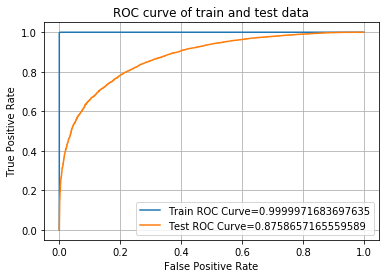

In [128]:
model_t2v = XGBClassifier(max_depth=optimal_depth_XGB_t2v,n_estimators=optimal_estimators_XGB_t2v,learning_rate=optimal_rate_XGB_t2v)
model_t2v.fit(tfidf_sent_vectors_train,y_train2)

y_pred_t2v = model_t2v.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr_t2v,tpr_t2v,t1= metrics.roc_curve(y_train2,y_pred_t2v)

y_pred_t2v2 = model_t2v.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr_t2v2,tpr_t2v2,t2= metrics.roc_curve(y_test,y_pred_t2v2)

plt.plot(fpr_t2v,tpr_t2v,label='Train ROC Curve=' +str(metrics.auc(fpr_t2v,tpr_t2v)))
plt.plot(fpr_t2v2,tpr_t2v2,label='Test ROC Curve=' +str(metrics.auc(fpr_t2v2,tpr_t2v2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.9981132075471698 for threshold 0.902
*********Train confusion matrix*********
[[ 6348    12]
 [    0 36648]]


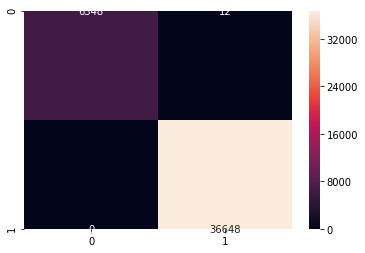

In [129]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr_t2v,tpr_t2v)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_t2v, best_t)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_t2v, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[ 2733  1823]
 [ 2025 19751]]


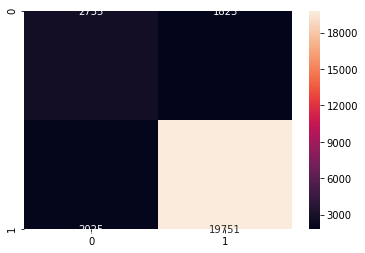

In [130]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_t2v2, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_t2v2, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

# [6] Conclusions

In [131]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable

x = PrettyTable(border=True)

x.field_names = ['Vectorizer','Model','Hyper Parameter - max_depth','Hyper Parameter2 - n_estimators','AUC']

x.add_row(['BOW','Random Forest',optimal_depth,optimal_estimators,best_auc_bow_rf])
x.add_row(['TF IDF','Random Forest',optimal_depth_tf,optimal_estimators_tf,best_auc_tfidf_rf])
x.add_row(['AVG W2V','Random Forest',optimal_depth_w2v,optimal_estimators_w2v,best_auc_w2v_rf])
x.add_row(['TF-IDF W2V','Random Forest',optimal_depth_t2v,optimal_estimators_t2v,best_auc_t2v_rf])

x.add_row(['----------------','----------------','---------------','---------------------------------','-------------'])

x.add_row(['BOW','XGBOOST',optimal_depth_XGB,optimal_estimators_XGB,best_auc_bow_xgb])
x.add_row(['TF IDF','XGBOOST',optimal_depth_XGB_tf,optimal_estimators_XGB_tf,best_auc_tfidf_xgb])
x.add_row(['AVG W2V','XGBOOST',optimal_depth_XGB_w2v,optimal_estimators_XGB_w2v,best_auc_w2v_xgb])
x.add_row(['TF-IDF W2V','XGBOOST',optimal_depth_XGB_t2v,optimal_estimators_XGB_t2v,best_auc_t2v_xgb])


print(x)

+------------------+------------------+-----------------------------+-----------------------------------+--------------------+
|    Vectorizer    |      Model       | Hyper Parameter - max_depth |  Hyper Parameter2 - n_estimators  |        AUC         |
+------------------+------------------+-----------------------------+-----------------------------------+--------------------+
|       BOW        |  Random Forest   |              50             |                300                | 0.8097150566625215 |
|      TF IDF      |  Random Forest   |             100             |                450                | 0.9232546591484679 |
|     AVG W2V      |  Random Forest   |             100             |                450                |  0.88269746352089  |
|    TF-IDF W2V    |  Random Forest   |             100             |                450                | 0.8564190710910144 |
| ---------------- | ---------------- |       ---------------       | --------------------------------- |   ---

# Conclusion

1. 100K data points were used for this assignment

2. Best performing model comes out to be XGBOOST on TFIDF data where the mean cross-validated score of the best_estimator comes out to be 0.9416040627117257

3. Overall RF and XGBOOST both have performed considerably well for this case